In [1]:
import os
import re
import yaml

In [2]:
def walk_in_data(rootdir=r"data"):
    for folder, _, files in os.walk(rootdir):
        print("visited", folder)
        for filename in files:
            print("visited file", filename)

In [3]:
walk_in_data()

visited data
visited file books_list.pdf
visited file ITldHoJsFlCJ9.djvu
visited file 2024-06-12.md
visited file 2024-06-13.md
visited file 2024-06-14.md
visited file 2024-06-19.md
visited file 2024-06-20.md
visited file 2024-06-21.md
visited file 2024-06-22.md
visited file 2024-06-23.md
visited file 2024-06-29.md
visited file 2024-07-04.md
visited file 2024-07-05.md
visited file Building a Corpus from GitHub Repositories.md
visited file lean.md
visited file make pipeline.md
visited file pip.md
visited file plan-b_question-mark.md
visited file Python.md
visited file tasks.md
visited file wandb.md
visited file количество полных квадратов в диапазоне от 1 до n.md
visited file RGIF2.gif
visited file Pasted image 20240125143318.png
visited file Pasted image 20240125143933.png
visited file Pasted image 20240125151831.png
visited file Pasted image 20240125151902.png
visited file Pasted image 20240125152143.png
visited file Pasted image 20240125152338.png
visited file Pasted image 20240125153

In [4]:
import pandas as pd

In [5]:
df = pd.DataFrame()


def walk_in_data_and_add(rootdir=r"data"):
    rows_list = []

    for folder, dirnames, files in os.walk(rootdir):
        for filename in files:
            if filename[-2:] != "md":
                continue
            with open(folder + "/" + filename, "r") as f:
                dict = {}
                dict.update({"directory": folder})
                dict.update({"name": ".".join(filename.split(".")[:-1])})
                dict.update({"extension": filename.split(".")[-1]})
                dict.update({"text": f.read()})

                rows_list.append(dict)
    return pd.DataFrame(rows_list)

In [6]:
df = walk_in_data_and_add()
df.to_csv("first.csv", index=False)
df

,directory,name,extension,text
0,data,2024-06-12,md,---\ntags:\n - daily\ndate: 2024-06-12\n---\n...
1,data,2024-06-13,md,---\ntags: daily \ndate: 2024-06-13\n---\n```d...
2,data,2024-06-14,md,---\ntags: daily \ndate: 2024-06-14\n---\n```d...
3,data,2024-06-19,md,---\ntags: daily \ndate: 2024-06-19\n---\n```d...
4,data,2024-06-20,md,---\ntags: daily \ndate: 2024-06-20\n---\n```d...
...,...,...,...,...
404,data/Private/stazhka/Примите меня в Яндекс,анкетка в ШАД,md,---\ntags:\n - shad\n---\n# 08.05.2024\n\nЯ с...
405,data/Private/stazhka/Примите меня в Яндекс,разборочка,md,"---\ntags: [todo, algorithms]\n---\n[Разбор ал..."
406,data/Private/stazhka/Примите меня в Яндекс/cod...,422. Две команды,md,"---\ntags: coderun, backend, yandex, difficult..."
407,data/Private/stazhka/Примите меня в Яндекс/cod...,423. Ближайшая остановка,md,---\ntags:\n - difficulty/easy\n - backend\n...


In [7]:
print(df["text"].iloc[0])

---
tags:
  - daily
date: 2024-06-12
---
```dataview
table without id
file.link as "Имя", date as "Дата", tags as Тэги, link as "Ссылка"
from ""
where date = date(2024-06-12) and !contains(tags, "daily")
sort date desc
```



Let's detect files that contain YAML front matter.

In [8]:
df_with_yaml = df[
    df["text"].str.contains(r"(?s)^---\s*\n(.*?)\n---\s*(\n|$)", regex=True)
]
df_with_yaml

/tmp/ipykernel_22686/1132983621.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["text"].str.contains(r"(?s)^---\s*\n(.*?)\n---\s*(\n|$)", regex=True)


,directory,name,extension,text
0,data,2024-06-12,md,---\ntags:\n - daily\ndate: 2024-06-12\n---\n...
1,data,2024-06-13,md,---\ntags: daily \ndate: 2024-06-13\n---\n```d...
2,data,2024-06-14,md,---\ntags: daily \ndate: 2024-06-14\n---\n```d...
3,data,2024-06-19,md,---\ntags: daily \ndate: 2024-06-19\n---\n```d...
4,data,2024-06-20,md,---\ntags: daily \ndate: 2024-06-20\n---\n```d...
...,...,...,...,...
404,data/Private/stazhka/Примите меня в Яндекс,анкетка в ШАД,md,---\ntags:\n - shad\n---\n# 08.05.2024\n\nЯ с...
405,data/Private/stazhka/Примите меня в Яндекс,разборочка,md,"---\ntags: [todo, algorithms]\n---\n[Разбор ал..."
406,data/Private/stazhka/Примите меня в Яндекс/cod...,422. Две команды,md,"---\ntags: coderun, backend, yandex, difficult..."
407,data/Private/stazhka/Примите меня в Яндекс/cod...,423. Ближайшая остановка,md,---\ntags:\n - difficulty/easy\n - backend\n...


In [9]:
df_with_yaml["yaml_content"] = df_with_yaml["text"].str.extract(
    r"(?s)^---\s*\n(.*?)\n---\s*(\n|$)", expand=False
)[0]
df_with_yaml

/tmp/ipykernel_22686/3232388725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_yaml["yaml_content"] = df_with_yaml["text"].str.extract(


,directory,name,extension,text,yaml_content
0,data,2024-06-12,md,---\ntags:\n - daily\ndate: 2024-06-12\n---\n...,tags:\n - daily\ndate: 2024-06-12
1,data,2024-06-13,md,---\ntags: daily \ndate: 2024-06-13\n---\n```d...,tags: daily \ndate: 2024-06-13
2,data,2024-06-14,md,---\ntags: daily \ndate: 2024-06-14\n---\n```d...,tags: daily \ndate: 2024-06-14
3,data,2024-06-19,md,---\ntags: daily \ndate: 2024-06-19\n---\n```d...,tags: daily \ndate: 2024-06-19
4,data,2024-06-20,md,---\ntags: daily \ndate: 2024-06-20\n---\n```d...,tags: daily \ndate: 2024-06-20
...,...,...,...,...,...
404,data/Private/stazhka/Примите меня в Яндекс,анкетка в ШАД,md,---\ntags:\n - shad\n---\n# 08.05.2024\n\nЯ с...,tags:\n - shad
405,data/Private/stazhka/Примите меня в Яндекс,разборочка,md,"---\ntags: [todo, algorithms]\n---\n[Разбор ал...","tags: [todo, algorithms]"
406,data/Private/stazhka/Примите меня в Яндекс/cod...,422. Две команды,md,"---\ntags: coderun, backend, yandex, difficult...","tags: coderun, backend, yandex, difficulty/eas..."
407,data/Private/stazhka/Примите меня в Яндекс/cod...,423. Ближайшая остановка,md,---\ntags:\n - difficulty/easy\n - backend\n...,tags:\n - difficulty/easy\n - backend\n - c...


Looks that dict column will be painful to use for ML algorithms. It is essential to extract features using `DictVectorizer`

In [10]:
def erase_yaml(row):
    len_of_yaml = 1 + len(row["yaml_content"]) + 8  # --- symbols + \n
    row["text"] = row["text"][len_of_yaml:]
    return row


df_with_yaml = df_with_yaml.apply(erase_yaml, axis="columns")
df_with_yaml

,directory,name,extension,text,yaml_content
0,data,2024-06-12,md,"```dataview\ntable without id\nfile.link as ""И...",tags:\n - daily\ndate: 2024-06-12
1,data,2024-06-13,md,"```dataview\ntable without id\nfile.link as ""И...",tags: daily \ndate: 2024-06-13
2,data,2024-06-14,md,"```dataview\ntable without id\nfile.link as ""И...",tags: daily \ndate: 2024-06-14
3,data,2024-06-19,md,"```dataview\ntable without id\nfile.link as ""И...",tags: daily \ndate: 2024-06-19
4,data,2024-06-20,md,"```dataview\ntable without id\nfile.link as ""И...",tags: daily \ndate: 2024-06-20
...,...,...,...,...,...
404,data/Private/stazhka/Примите меня в Яндекс,анкетка в ШАД,md,"# 08.05.2024\n\nЯ стремлюсь к тому, чтобы нако...",tags:\n - shad
405,data/Private/stazhka/Примите меня в Яндекс,разборочка,md,[Разбор алгоритмов на стажировку в Яндекс!! (y...,"tags: [todo, algorithms]"
406,data/Private/stazhka/Примите меня в Яндекс/cod...,422. Две команды,md,```cpp\n#include <iostream>\n#include <string>...,"tags: coderun, backend, yandex, difficulty/eas..."
407,data/Private/stazhka/Примите меня в Яндекс/cod...,423. Ближайшая остановка,md,```CPP\n#include <iostream>\n#include <string>...,tags:\n - difficulty/easy\n - backend\n - c...


In [11]:
def preprocess_yaml(row):
    row = yaml.safe_load(row) if pd.notnull(row) else None
    if row == None:
        return row
    for key in row.keys():
        if isinstance(row[key], list) and len(row[key]) == 1:
            row[key] = row[key][0]
    return row


df_with_yaml["yaml_content"] = df_with_yaml["yaml_content"].apply(preprocess_yaml)
df_with_yaml["yaml_content"]

0                  {'tags': 'daily', 'date': 2024-06-12}
1                  {'tags': 'daily', 'date': 2024-06-13}
2                  {'tags': 'daily', 'date': 2024-06-14}
3                  {'tags': 'daily', 'date': 2024-06-19}
4                  {'tags': 'daily', 'date': 2024-06-20}
                             ...                        
404                                     {'tags': 'shad'}
405                     {'tags': ['todo', 'algorithms']}
406    {'tags': 'coderun, backend, yandex, difficulty...
407    {'tags': ['difficulty/easy', 'backend', 'coder...
408    {'tags': 'ml, yandex, coderun, difficulty/easy...
Name: yaml_content, Length: 374, dtype: object

In [12]:
df_with_yaml

,directory,name,extension,text,yaml_content
0,data,2024-06-12,md,"```dataview\ntable without id\nfile.link as ""И...","{'tags': 'daily', 'date': 2024-06-12}"
1,data,2024-06-13,md,"```dataview\ntable without id\nfile.link as ""И...","{'tags': 'daily', 'date': 2024-06-13}"
2,data,2024-06-14,md,"```dataview\ntable without id\nfile.link as ""И...","{'tags': 'daily', 'date': 2024-06-14}"
3,data,2024-06-19,md,"```dataview\ntable without id\nfile.link as ""И...","{'tags': 'daily', 'date': 2024-06-19}"
4,data,2024-06-20,md,"```dataview\ntable without id\nfile.link as ""И...","{'tags': 'daily', 'date': 2024-06-20}"
...,...,...,...,...,...
404,data/Private/stazhka/Примите меня в Яндекс,анкетка в ШАД,md,"# 08.05.2024\n\nЯ стремлюсь к тому, чтобы нако...",{'tags': 'shad'}
405,data/Private/stazhka/Примите меня в Яндекс,разборочка,md,[Разбор алгоритмов на стажировку в Яндекс!! (y...,"{'tags': ['todo', 'algorithms']}"
406,data/Private/stazhka/Примите меня в Яндекс/cod...,422. Две команды,md,```cpp\n#include <iostream>\n#include <string>...,"{'tags': 'coderun, backend, yandex, difficulty..."
407,data/Private/stazhka/Примите меня в Яндекс/cod...,423. Ближайшая остановка,md,```CPP\n#include <iostream>\n#include <string>...,"{'tags': ['difficulty/easy', 'backend', 'coder..."


# TF-IDF

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def get_word_cloud(text, ngram_range=(1, 1)):
    vec = TfidfVectorizer(ngram_range=ngram_range)
    X = vec.fit_transform(text)
    words_tfidf = dict(zip(vec.get_feature_names_out(), X.sum(axis=0).A1)) # np.asarray(X.sum(axis=0)).ravel()
    wordCloud = WordCloud(
        width=2000, height=1000, random_state=42, background_color="white"
    ).generate_from_frequencies(words_tfidf)

    plt.figure(figsize=(10, 5))
    plt.axis("off")
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.show()

## A bit of visualization

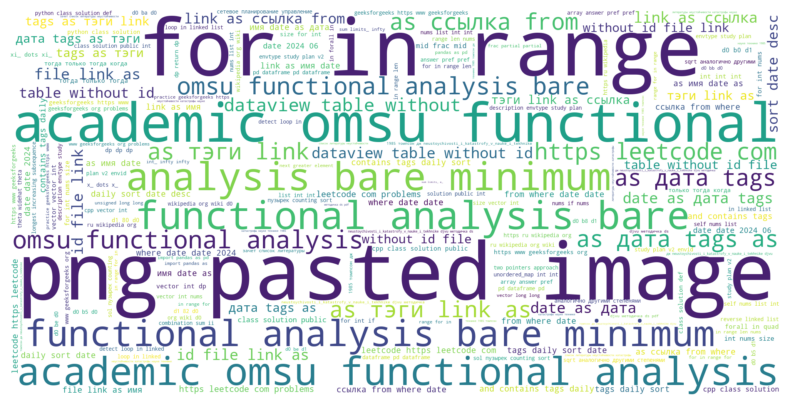

In [46]:
get_word_cloud(df_with_yaml['text'], (3, 4))